# Linear Regression


In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
import plotly.express as px
import plotly.graph_objects as go

## Load and preprocess data
Now I use pandas to read the data and do some preprocessing. 
- Check whether there is any missing value
- Drop feature 'Address' which is useless in constructing model
- Transform dependent variables and target variable into torch tensors and also store the number of samples in a variable n_samples.
- Standardise the data : write a routine named **Standardise** that takes an argument data_matrix as its input and returns a matrix where all columns have mean zero and standard deviation one, and all elements are done in PyTorch instead of Numpy. Subquently, I set up the data_matrix as 

$$ \text{data_matrix} = X := \left( \begin{matrix} 1 & x_1 \\ 1 & x_2 \\ \vdots & \vdots \\ 1 & x_{\text{n_samples}} \end{matrix} \right) \, ,$$

where the $x_i$, $i \in \{1, \ldots, \text{n_samples}\}$ are the standardised elements of the dependent vectors.

In [2]:
data = pd.read_csv(r'D:\python\QMUL Machine_Learning_with_Python\Semester2\coursework1\USA_Housing.csv')
data.head()

,Avg. Area Income,Avg. Area House Age,Avg. Area Number of Rooms,Avg. Area Number of Bedrooms,Area Population,Price,Address
0,79545.458574,5.682861,7.009188,4.09,23086.800503,1.059034e+06,"208 Michael Ferry Apt. 674\nLaurabury, NE 3701..."
1,79248.642455,6.002900,6.730821,3.09,40173.072174,1.505891e+06,"188 Johnson Views Suite 079\nLake Kathleen, CA..."
2,61287.067179,5.865890,8.512727,5.13,36882.159400,1.058988e+06,"9127 Elizabeth Stravenue\nDanieltown, WI 06482..."
3,63345.240046,7.188236,5.586729,3.26,34310.242831,1.260617e+06,USS Barnett\nFPO AP 44820
4,59982.197226,5.040555,7.839388,4.23,26354.109472,6.309435e+05,USNS Raymond\nFPO AE 09386


In [3]:
data = data.drop(columns='Address')
data.isnull().any()

Avg. Area Income                False
Avg. Area House Age             False
Avg. Area Number of Rooms       False
Avg. Area Number of Bedrooms    False
Area Population                 False
Price                           False
dtype: bool

In [4]:
mat = torch.from_numpy(data.iloc[:,0:5].values)
price = torch.from_numpy(data.Price.values)
n_samples = torch.numel(price)

In [5]:
def standardise(data_matrix):
    return data_matrix - torch.mean(data_matrix, axis=0) / torch.std(data_matrix, axis=0)

data_mat = torch.cat((torch.ones((n_samples, 1), dtype = torch.float64), standardise(mat).view(n_samples, -1)), 1)

## Simple Linear Regression
Next, we implement a simple linear regression in PyTorch with the help of the normal equations:
$$ X^\top X \hat w = X^\top y\, ,$$
where $X$ is our mathematical notation for the variable *data_mat*, $\hat w$ denotes the variable *optimal_weights* and $y$ the data *Price*. We can compute $\hat w$, respectively *optimal_weights*, by solving the linear system above. In PyTorch, we do this via **solve**-command.

In [6]:
# torch.mm : matrix multiplication
left = torch.mm(data_mat.t(), data_mat)
# torch.mv : matrix-vector product
right = torch.mv(data_mat.t(), price)

#torch.solve(B, A) : AX=B find X
opt_weights, LU = torch.solve(right.view(-1,1), left)
print(opt_weights)

tensor([[-7.9494e+05],
        [ 2.1578e+01],
        [ 1.6564e+05],
        [ 1.2066e+05],
        [ 1.6511e+03],
        [ 1.5201e+01]], dtype=torch.float64)


## Compute the gradient of MSE
Here we use PyTorch's automatic differentiation to do so. We write a function **MSE** to implement the mean-squared error between the data model and the output data in PyTorch.

$$\text{MSE}(w)=\frac{1}{2n}||Xw-y||^2\,,$$
where $w$ and $n$ are the mathematical notations for the variable weights and n_samples, respectively.  
  
Before we automatically differentiate, we first write a routine that manually computes the gradient $\nabla \text{MSE}(w)$ of the MSE function in order to compare the result of this routine with the automatic differentiation routines.

$$ \frac{\Delta \text{MSE} (w)}{\Delta w} = \frac{1}{n} X^T |Xw-y|$$
Note that $|Xw-y|$ is a vector, so we have to use torch.mv to multiply them.

In [7]:
def MSE(weights):
    return 1/2 * torch.mean((torch.mv(data_mat, weights.view(-1)) - price)**2)
def manual_MSE(weights):
    return 1/n_samples * torch.mv(data_mat.t(), torch.mv(data_mat, weights.view(-1)) - price)

We first compute the gradient of MSE function with respect to the variable optomal weights, or $\hat{w}$ in mathematical notation. We therefore set **requires_grad_** property of the corresponding tensor to **True**. This will enable us to compute the gradient of the function.  
The next step is to **backpropagate** this error via **.backward()** on the tensor. Autograd then calculates and stores the gradients in the parameter's **.grad** attributes.

In [8]:
opt_weights.requires_grad_(True)
loss_func = MSE(opt_weights)
loss_func.backward()
print('PyTorch Autograd : \n',opt_weights.grad, '\n\n', 'Manual Gradient : \n',manual_MSE(opt_weights).view(-1, 1))

PyTorch Autograd : 
 tensor([[ 1.1054e-09],
        [ 4.5449e-07],
        [-4.5119e-13],
        [ 5.1294e-11],
        [ 2.6917e-10],
        [ 2.5705e-07]], dtype=torch.float64) 

 Manual Gradient : 
 tensor([[ 1.1048e-09],
        [ 3.9063e-07],
        [-4.3656e-13],
        [ 5.0379e-11],
        [ 2.6957e-10],
        [ 1.1597e-07]], dtype=torch.float64, grad_fn=<ViewBackward>)


As we would expect, coth gradients are basically zero in terms of machine precision. We repeat the experienment with random weights and again comapre the results. And as the result below, the gradient are the same.

In [9]:
torch.manual_seed(576)
random_w = torch.randn(6, requires_grad=True, dtype=torch.float64)
loss_func = MSE(random_w)
loss_func.backward()
print('PyTorch Autograd : \n',random_w.grad.view(-1, 1), '\n\n', 'Manual Gradient : \n',manual_MSE(random_w).view(-1, 1))

PyTorch Autograd : 
 tensor([[-1.3036e+06],
        [-9.1902e+10],
        [-9.1169e+04],
        [-1.7193e+05],
        [-1.0593e+06],
        [-4.8607e+10]], dtype=torch.float64) 

 Manual Gradient : 
 tensor([[-1.3036e+06],
        [-9.1902e+10],
        [-9.1169e+04],
        [-1.7193e+05],
        [-1.0593e+06],
        [-4.8607e+10]], dtype=torch.float64, grad_fn=<ViewBackward>)


## Gradient Descent
To conclude, we implement gradient descent in order to minimise the MSE iteratively :  

$$w^{t+1} = w^{t} - \tau \Delta \text{MSE}(w^t)\,,$$

where $\tau$ is the step size of gradient descent.  
  
Frobenius norm is defined as :  
$$||A||_{F} = \sqrt{||a_1||^2 + ... + ||a_n||^2} = \sqrt{\sum_{i=1}^{m}|a_{i1}|^2 + ... + \sum_{i=1}^{m}|a_{in}|^2} = \sqrt{\sum_{i=1}^{m}\sum_{j=1}^{n}|a_{ij}|^2} = \sqrt{\text{trace}(A^{*}A)}$$

In [10]:
weights = torch.zeros(6, dtype=torch.float64, requires_grad=True)
step_size = 2 * n_samples / torch.norm(data_mat, 'fro')**2
max_iters = 10000
losses = []

for counters in range(max_iters):
    loss_func = MSE(weights)
    losses.append(loss_func.item())    # torch.Tensor.item() : get a Python number from a tensor containing a single value
    loss_func.backward()
    with torch.no_grad():
        weights = weights - step_size * weights.grad
    weights.requires_grad_(True)
    if counters % 1000 == 0:
        print('Gradient Descent ({iters}/{max_iters}): loss = {l}'.format(
            iters = counters, max_iters = max_iters-1, l = losses[counters]))
losses.append(loss_func.item())

weights.requires_grad_(False)
print('Gradient Descent completed: weights = {w}, loss = {l}'.format(
            w = weights, l = loss_func.item()))

Gradient Descent (0/9999): loss = 821335072437.9965
Gradient Descent (1000/9999): loss = 31212417169.817875
Gradient Descent (2000/9999): loss = 31212402839.735706
Gradient Descent (3000/9999): loss = 31212388509.664864
Gradient Descent (4000/9999): loss = 31212374179.605324
Gradient Descent (5000/9999): loss = 31212359849.557095
Gradient Descent (6000/9999): loss = 31212345519.520195
Gradient Descent (7000/9999): loss = 31212331189.494595
Gradient Descent (8000/9999): loss = 31212316859.480312
Gradient Descent (9000/9999): loss = 31212302529.47735
Gradient Descent completed: weights = tensor([-0.0440, 13.0433,  0.5181,  0.3857,  0.2039,  9.7166],
       dtype=torch.float64), loss = 31212288213.815693


For second implementation of gradient descent we use the built-in (stochastic) gradient descent solver **SGD**. Otherwise we proceed in identical fashion.

In [11]:
weights = torch.zeros(6, dtype=torch.float64, requires_grad=True)
data_mat = data_mat.requires_grad_(True)
price = price.requires_grad_(True)
step_size = 2 * n_samples / torch.norm(data_mat, 'fro')**2
optimiser = optim.SGD([weights], lr=step_size.item())
max_iters = 10000
losses = []

for counters in range(max_iters):
    # set the gradients to zero before starting to do backpropragation
    # because PyTorch accumulates the gradients on subsequent backward passes
    optimiser.zero_grad() 
    loss_func = MSE(weights)
    losses.append(loss_func.item())
    loss_func.backward()
    optimiser.step()  # updates the parameters
    if counters % 1000 == 0:
        print('Gradient Descent ({iters}/{max_iters}): loss = {l}'.format(
            iters = counters, max_iters = max_iters-1, l = losses[counters]))

weights.requires_grad_(False)
print('Gradient Descent completed: weights = {w}, loss = {l}'.format(
            w = weights, l = loss_func.item()))

Gradient Descent (0/9999): loss = 821335072437.9965
Gradient Descent (1000/9999): loss = 31212417169.817875
Gradient Descent (2000/9999): loss = 31212402839.735706
Gradient Descent (3000/9999): loss = 31212388509.664864
Gradient Descent (4000/9999): loss = 31212374179.605324
Gradient Descent (5000/9999): loss = 31212359849.557095
Gradient Descent (6000/9999): loss = 31212345519.520195
Gradient Descent (7000/9999): loss = 31212331189.494595
Gradient Descent (8000/9999): loss = 31212316859.480312
Gradient Descent (9000/9999): loss = 31212302529.47735
Gradient Descent completed: weights = tensor([-0.0440, 13.0433,  0.5181,  0.3857,  0.2039,  9.7166],
       dtype=torch.float64), loss = 31212288213.815693


# Polynomial Regression
Here we begin by defining the function $\text{sin}(2 \pi x)$ over the interval [0, 1] in PyTorch and by drawing noisy data samples from it.

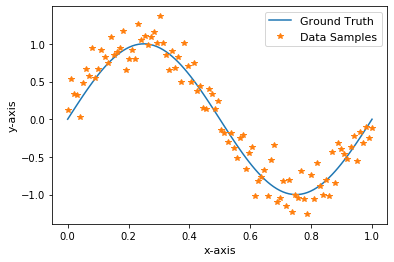

In [12]:
plot_fontsize = 11
n_samples = 100
noise_std = 0.2
input_data = torch.linspace(0, 1, steps = n_samples, dtype=torch.float64)
true_output = torch.sin(2 * np.pi * input_data)
torch.manual_seed(576)
output_data = true_output + noise_std * torch.randn(n_samples, dtype = torch.float64)

plt.plot(input_data, true_output, label='Ground Truth')
plt.plot(input_data, output_data, '*', label='Data Samples')
plt.xlabel('x-axis', fontsize = plot_fontsize)
plt.ylabel('y-axis', fontsize = plot_fontsize)
plt.legend(loc='best', fontsize = plot_fontsize)
plt.show()

In the following, we define the function **polynomial_augmented_data** that  takes two arguments, a torch tensor **input_data** and a scalar **polynomial_degree**, and returns a matrix $\Phi (X) \in \text{R}^{s \times (d+1)}$. Here $d$ is the mathematical notation of the variable polynomial_degree, whereas input_data are the input points $\{ x_i \}_{i=1}^{s}$. We also define a function **polynomial_model** and **least_square_sol** that evaluate $\Phi(X)w$, where $\Phi(X)$ denotes the augmented data matrix and $w$ the weights, and solve $\Phi(X)^T \Phi(X) w = \Phi(X)^T y$ respectively.

In [13]:
def polynomial_augmented_data(input_data, poly_degree):
    data_mat = input_data.view(-1, 1).pow(0)
    for i in range(poly_degree):
        data_mat = torch.cat((data_mat, input_data.view(-1, 1).pow(i+1)), 1)  # concate at the second dimension
    return data_mat

def polynomial_model(augmented_data, weights):
    return torch.mv(augmented_data, weights.view(-1))

def least_square_sol(augmented_data, outputs):
    left = torch.mm(augmented_data.t(), augmented_data)
    right = torch.mv(augmented_data.t(), outputs)
    opt_weights, LU = torch.solve(right.view(-1, 1), left)
    return opt_weights

We test the function for a polynomial of degree 7 with the following code snippet and visualize the model approximation together with the true function and the noisy data samples.

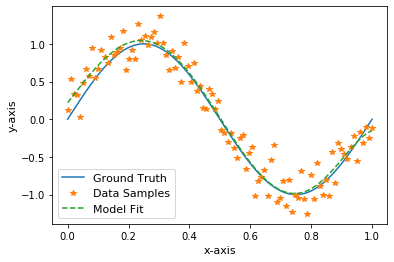

In [14]:
degrees = 7
augmented_data = polynomial_augmented_data(input_data, degrees)
optimal_weights = least_square_sol(augmented_data, output_data)
model_outputs = polynomial_model(augmented_data, optimal_weights)

plt.plot(input_data, true_output, label='Ground Truth')
plt.plot(input_data, output_data, '*', label='Data Samples')
plt.plot(input_data, model_outputs, '--', label='Model Fit')
plt.xlabel('x-axis', fontsize=plot_fontsize)
plt.ylabel('y-axis', fontsize=plot_fontsize)
plt.legend(loc='lower left', fontsize=plot_fontsize)
plt.show()

# Bias-variance decomposition
## Sin(2 pi x)
We define a whole range of noisy data samples from $\sin(2\pi x)$. We specify a fixed number of sets **n_sets** where each set contains **n_sample_set** samples, stored in the variable **train_input** and **train_output**.

In [15]:
fontsize = 11
n_sets = 100
n_samples_set = 200
n_total_samples = n_sets * n_samples_set
noise_std = 0.5
torch.manual_seed(576)
train_input = torch.linspace(0, 1, steps=n_total_samples, dtype=torch.float64)
train_input = train_input[torch.randperm(n_total_samples)] # random permutation
train_input, _ = torch.sort(train_input.view(n_sets, n_samples_set), 1)
train_output = torch.sin(2 * np.pi * train_input) + noise_std * torch.randn(n_sets, n_samples_set, dtype=torch.float64)

We define a finely discretised validation dataset and visualisation both the training and the validation data.

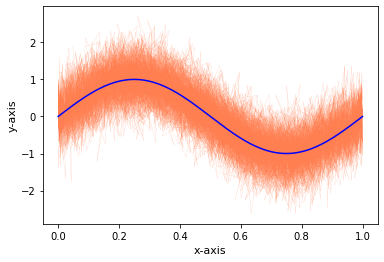

In [16]:
n_validation_samples = 800
validation_input = torch.linspace(0, 1, steps=n_validation_samples, dtype=torch.float64)
true_output = torch.sin(2 * np.pi * validation_input)

plt.plot(train_input, train_output, '-', color='coral', linewidth=0.1, label='Validation data')
plt.plot(validation_input, true_output, color='blue', label='Ground Truth')
plt.xlabel('x-axis', fontsize=fontsize)
plt.ylabel('y-axis', fontsize=fontsize)
plt.show()

## Ridge Regression
Subquently, we write a function **ridge_regression_squares** that computes the least-squares solution of the ridge regression problem.  

$$ w_t = \arg \min_{w \in \mathbb{R}^{d+1}} \left \{ \frac{1}{2} || \Phi(X)w-y||^2 + \frac{\alpha}{2}||w||^2 \right \} $$
  
$$\begin{aligned}
\Phi(X)^T( \Phi(X) \hat{w} - y) + \alpha \hat{w} = 0 \\
( \Phi(X)^T \Phi(X) - \alpha) \hat{w} = \Phi(X)^T y\\
\end{aligned}$$

where $w_t$ is the mathematical notation of the return variable weights, $\alpha$ the regularisation parameter input variable **regularisation_param**, and the inputs **gram_matrix** and **transformed_output** stands for $\Phi(X)^T \Phi(X)$ and $\Phi{X}^ty$, respectively.

In [17]:
def ridge_regression_squares(gram_matrix, transformed_output, regularisation_param):
    shifted_gram_matrix = gram_matrix + regularisation_param * torch.eye(gram_matrix.size(0)) # torch.eye : identity matrix
    weights, _ = torch.solve(transformed_output.view(-1,1), shifted_gram_matrix)
    return weights.view(-1)

Within the following code snippet, we train optimal weights for the disserent data samples.

In [18]:
degrees = 30
regularisation_param_grid_size = 100
regularisation_params = torch.logspace(-7, 1, steps=regularisation_param_grid_size)

weights = torch.zeros(degrees + 1, n_sets, regularisation_param_grid_size, dtype=torch.float64)
for i in range(regularisation_param_grid_size):
    for j in range(n_sets):
        train_data = polynomial_augmented_data(train_input[i, :], degrees)
        gram_matrix = torch.mm(train_data.t(), train_data)
        transformed_otuput = torch.mv(train_data.t(), train_output[i, :])
        weights[:, i, j] = ridge_regression_squares(gram_matrix, transformed_otuput, regularisation_params[j])

We can validate the trained parameters by applying the trained models to the validation data, and by visualising different model approximations.

The shape of model_outputs(n_samples*n_sets*n_models) :  torch.Size([800, 100, 100]) 
The shape of expected_model_outputs(avegrage all sets' outputs) :  torch.Size([800, 100])


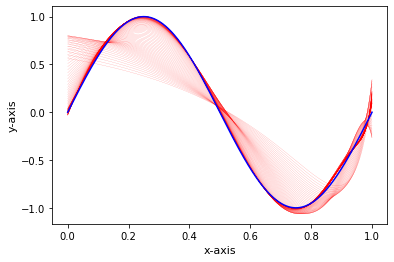

In [19]:
validation_matrix = polynomial_augmented_data(validation_input, degrees)
model_outputs = torch.mm(validation_matrix, weights.view(degrees + 1, -1)).view(-1, n_sets, regularisation_param_grid_size)
expected_model_outputs = model_outputs.mean(1) # average all sets
print('The shape of model_outputs(n_samples*n_sets*n_models) : ',model_outputs.shape,\
      "\nThe shape of expected_model_outputs(avegrage all sets' outputs) : ", expected_model_outputs.shape)

plt.plot(validation_input.view(n_validation_samples, 1),
         expected_model_outputs, color='red', linewidth=0.1)
plt.plot(validation_input, true_output, color='blue', label='Ground Truth')
plt.xlabel('x-axis', fontsize=fontsize)
plt.ylabel('y-axis', fontsize=fontsize)
plt.show()

### Bias
With the following code, we can visualize the average squared bias

$$\text{Bias}_t(f_{w_t}(x))^2 = \left( \mathbb{E}_t[f_{w_t}(x)] - \hat{f}(x) \right)^2$$

for all regularisation parameters.

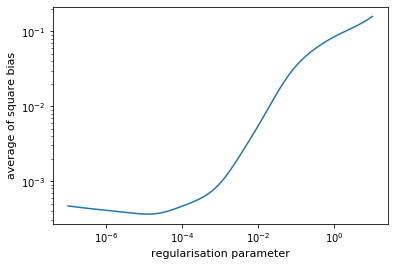

In [20]:
bias = expected_model_outputs - true_output.view(-1, 1).expand(n_validation_samples, regularisation_param_grid_size)

plt.plot(regularisation_params, bias.pow(2).mean(0)) # avg for each set
plt.xscale('log')
plt.yscale('log')
plt.xlabel('regularisation parameter', fontsize=fontsize)
plt.ylabel('average of square bias', fontsize=fontsize)
plt.show()

### Variance
And we do the same for the average variance

$$\text{Var}_t[f_{w_t}(x)] = \mathbb{E}_t \left[ (f_{w_t}(x) - \mathbb{E}_t[f_{w_t}(x)])^2 \right]$$

for all regularisation parameters.

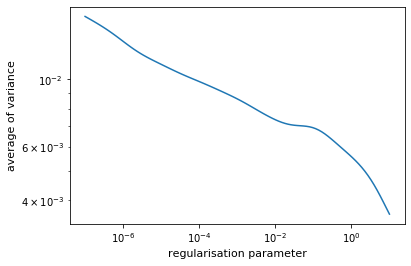

In [21]:
variance = (model_outputs - expected_model_outputs.view(-1, 1, regularisation_param_grid_size)).pow(2).mean(1)

plt.plot(regularisation_params, variance.mean(0))
plt.xscale('log')
plt.yscale('log')
plt.xlabel('regularisation parameter', fontsize=fontsize)
plt.ylabel('average of variance', fontsize=fontsize)
plt.show()

### Mean Squared Error

We then sum the averaged squared bias, variance and the noise variance to plot the average MSE.

The best regularisation parameter is :  tensor(0.0011)


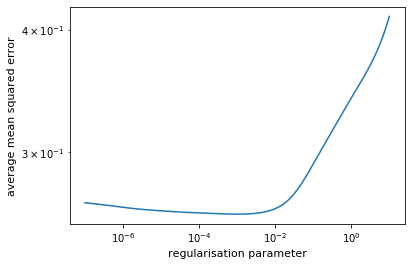

In [22]:
averageMSE = bias.pow(2).mean(0).numpy() + variance.mean(0).numpy() + noise_std ** 2
print('The best regularisation parameter is : ', regularisation_params[averageMSE.argmin()])

plt.plot(regularisation_params, averageMSE)
plt.xscale('log')
plt.yscale('log')
plt.xlabel('regularisation parameter', fontsize=fontsize)
plt.ylabel('average mean squared error', fontsize=fontsize)
plt.show()

### Conclude
Conclude this part by plotting all quantities in one plot.

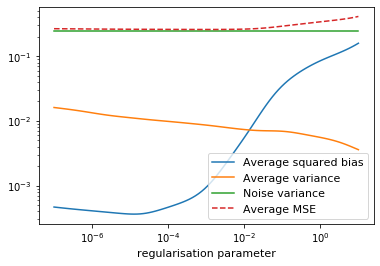

In [23]:
plt.plot(regularisation_params, bias.pow(2).mean(0), label='Average squared bias')
plt.plot(regularisation_params, variance.mean(0), label='Average variance')
plt.plot(regularisation_params, (noise_std**2) * torch.ones(regularisation_param_grid_size), label='Noise variance')
plt.plot(regularisation_params, averageMSE, '--', label='Average MSE')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('regularisation parameter', fontsize=fontsize)
plt.legend(loc='best', fontsize=fontsize)
plt.show()

# Optimal Regularisation Parameter Selection For The Validation Error
We define one additional function **MSE** and the class **ridge_regression**. The class is a sub-class of the neural network base-class **nn.Module**, which usually consists of a contrictor and a routine named **forward** that evaluates the network. 

In [24]:
def MSE(arg1, arg2):
    return 1/2 * torch.mean((arg1 - arg2) ** 2)

class ridge_regression(nn.Module):
    def __init__(self, gram_matrix, transformed_output):  # declare objects
        super(ridge_regression, self).__init__()
        self.gram_matrix = gram_matrix
        self.transformed_output = transformed_output
        self.regualrisation_parameter = nn.Parameter((10**(-1)) * torch.ones(1, dtype=torch.float64))
        
    def forward(self):
        return ridge_regression_squares(self.gram_matrix, self.transformed_output, self.regualrisation_parameter)

# Initialise Data
We initialise some training dta for the ridge regresion model and some validation data in order to optimise for the regularisation paramete. Subquently, we visualise those data points.

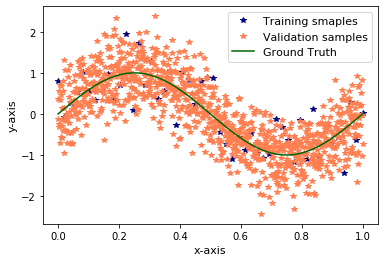

In [25]:
n_train_samples = 50
noise_std = 0.5
train_input = torch.linspace(0, 1, steps=n_train_samples, dtype=torch.float64)
true_output = torch.sin(2 * np.pi * train_input)
torch.manual_seed(13)
train_output = true_output + noise_std * torch.randn(n_train_samples, dtype=torch.float64)

n_validation_samples = 1000
validation_input = torch.linspace(0, 1, steps=n_validation_samples, dtype=torch.float64)
torch.manual_seed(14)
validation_output = torch.sin(2 * np.pi * validation_input) + noise_std * torch.randn(n_validation_samples, dtype=torch.float64)

plt.plot(train_input, train_output, '*', color='navy', label='Training smaples')
plt.plot(validation_input, validation_output, '*', color='coral', label='Validation samples')
plt.plot(train_input, true_output, color='darkgreen', label='Ground Truth')
plt.xlabel('x-axis', fontsize=fontsize)
plt.ylabel('y-axis', fontsize=fontsize)
plt.legend(loc='best', fontsize=fontsize)
plt.show()

# Initialise Model
We now initialise the ridge regression model with a poltnomial of degree 30.

In [26]:
degrees = 30
train_data = polynomial_augmented_data(train_input, degrees)
validation_data = polynomial_augmented_data(validation_input, degrees)
gram_matrix = torch.mm(train_data.t(), train_data)
transformed_output = torch.mv(train_data.t(), train_output)
regularisation = ridge_regression(gram_matrix, transformed_output)

As a sanity check we apply the initialisation of the model and **ridge_regression_squares** with regularisation parameter $\alpha = 10^{-1}$ in order to see that they coincide.

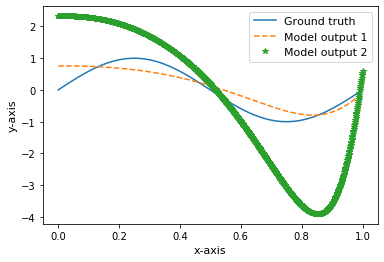

In [27]:
weights1 = regularisation()
weights2 = ridge_regression_squares(gram_matrix, transformed_otuput, 10**(-1))

model_outputs1 = polynomial_model(validation_data, weights1)
model_outputs2 = polynomial_model(validation_data, weights2)

# detach() : return a new tensor from the present tensor but requires_grad = false
plt.plot(train_input, true_output, label='Ground truth')
plt.plot(validation_input, model_outputs1.detach(), '--', label='Model output 1')
plt.plot(validation_input, model_outputs2.detach(), '*', label='Model output 2')
plt.xlabel('x-axis', fontsize=fontsize)
plt.ylabel('y-axis', fontsize=fontsize)
plt.legend(loc='best', fontsize=fontsize)
plt.show()

Now we compute the regularisation parameter via gradient descent.

In [28]:
outer_step_size = 10 ** (-4)
max_iters = 10000

optimiser = optim.SGD(regularisation.parameters(), lr=outer_step_size)

losses = []
for i in range(max_iters):
    optimiser.zero_grad()
    weights = regularisation()
    model_output = polynomial_model(validation_data, weights)
    validation_err = MSE(model_output, validation_output)
    losses.append(validation_err.item())
    validation_err.backward()
    optimiser.step()
    if i % 1000 == 0:
        print('Gradient descent ({it}/{max_iter}) : loss={l}'.format(it=i, max_iter=max_iters-1, l=losses[i]))
losses.append(validation_err.item())

print('Gradient descent completed : regularisation parameter = {alpha}, loss={l}'.format(
    alpha=regularisation.regualrisation_parameter.detach().numpy(), l=validation_err.item()))

Gradient descent (0/9999) : loss=0.17646032843088355
Gradient descent (1000/9999) : loss=0.17478386559043604
Gradient descent (2000/9999) : loss=0.17241050972346378
Gradient descent (3000/9999) : loss=0.1683578657864781
Gradient descent (4000/9999) : loss=0.15412699647807696
Gradient descent (5000/9999) : loss=0.14189086932095757
Gradient descent (6000/9999) : loss=0.14189086932095757
Gradient descent (7000/9999) : loss=0.14189086932095732
Gradient descent (8000/9999) : loss=0.14189086932095732
Gradient descent (9000/9999) : loss=0.14189086932095732
Gradient descent completed : regularisation parameter = [0.00050253], loss=0.14189086932095757


We conclude by visualising the model output with the estimated regularisation parameter.

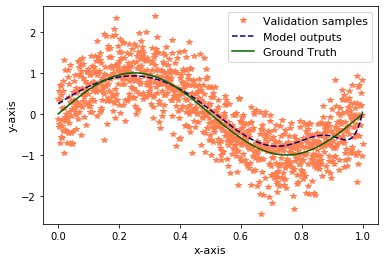

In [29]:
plt.plot(validation_input, validation_output, '*', color='coral', label='Validation samples')
plt.plot(validation_input, model_output.detach(), '--', color='navy', label='Model outputs')
plt.plot(train_input, true_output, color='darkgreen', label='Ground Truth')
plt.xlabel('x-axis', fontsize=fontsize)
plt.ylabel('y-axis', fontsize=fontsize)
plt.legend(loc='best', fontsize=fontsize)
plt.show()